In [ ]:
%pip install yfinance

In [ ]:
%pip install PyPortfolioOpt

In [ ]:
%pip install scikit-learn

In [3]:
# Cool data
import yfinance as yf

# The usual suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Use PyPortfolioOpt for Calculations
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import DiscreteAllocation

In [38]:
# Create a portfolio
symbols = [
    'TSLA',
    'MSFT',
    'NVDA',
    'GOOGL',
    'CRSP'
]

In [39]:
portfolio = yf.download(symbols, start='2018-01-01', end='2023-07-24')['Adj Close']

portfolio.head()

[*********************100%***********************]  5 of 5 completed


,CRSP,GOOGL,MSFT,NVDA,TSLA
Date,,,,,
2018-01-02,25.170000,53.660500,80.562057,49.321182,21.368668
2018-01-03,23.520000,54.576000,80.936974,52.567204,21.150000
2018-01-04,23.910000,54.787998,81.649330,52.844311,20.974667
2018-01-05,26.809999,55.514500,82.661613,53.292118,21.105333
2018-01-08,26.070000,55.710499,82.745995,54.925022,22.427334


In [81]:
# S&P 500 ETF Benchmark
market_prices = yf.download('SPY', start='2018-01-01', end='2023-07-24')['Adj Close']

market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
2018-01-02    244.918640
2018-01-03    246.467834
2018-01-04    247.506683
2018-01-05    249.155991
2018-01-08    249.611633
Name: Adj Close, dtype: float64

In [82]:
# Grab Market Cap for each stock in portfolio
mcaps = {}
for t in symbols:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info['marketCap']
    
print(mcaps)

{'TSLA': 840804925440, 'MSFT': 2609708269568, 'NVDA': 1128271314944, 'GOOGL': 1553692360704, 'CRSP': 4376162304}


## Get Priors

In [83]:
# Estimate the covariance matrix of the portfolio returns.
# The Ledoit-Wolf method is a type of covariance matrix estimation 
# that uses shrinkage to improve the estimate.
# Shrinkage is a technique that pulls extreme values towards a central value to reduce their impact. 
# This can help in reducing the error in the covariance matrix estimate.
S = risk_models.CovarianceShrinkage(portfolio).ledoit_wolf()

# Calculate the market-implied risk aversion parameter, which is a measure of the relative risk tolerance of the market.
# It's derived from the assumption that the market portfolio is optimal under the mean-variance optimization framework.
# The function uses the formula: delta = (Excess market return) / (Annualized market variance)
# The higher the delta, the lower the risk tolerance, meaning the market is more risk-averse.
# The `market_prices` variable contains the time series of market prices or market index.
delta = black_litterman.market_implied_risk_aversion(market_prices)

print(delta)

2.5745356294760926


In this context, `delta` is a measure of risk aversion in the Black-Litterman model. It is inferred from the market data based on the assumption that the market portfolio is the optimal portfolio.

The Ledoit-Wolf shrinkage technique is used to estimate the covariance matrix `S`. It's a method for estimating a large covariance matrix by "shrinking" towards a structured estimator. This can help to reduce estimation error, especially when the number of observations is small.

<Axes: >

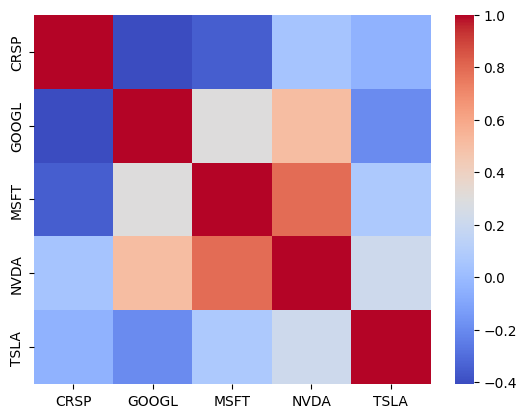

In [90]:
# Create a heatmap of the correlation matrix derived from the covariance matrix 'S'.
sns.heatmap(S.corr(), cmap='coolwarm')

The correlation matrix provides a measure of how much each asset's returns move in relation to every other asset's returns.
A value of 1 means two assets move perfectly in sync, -1 means they move exactly opposite, and 0 means there is no relationship.
It's a helpful visualization tool for understanding the relationships between different assets in the portfolio.
The 'coolwarm' colormap ranges from cool/blue colors for low correlation values, to warm/red colors for high correlation values.


### Let's Notice:
* NVDA and MSFT are highly correlated.
* NVDA and GOOGL are highly correlated.
* GOOGLE and CRSP are not correlated.
* Pretty neat

In [88]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
print(market_prior)

CRSP     0.270324
GOOGL    0.247107
MSFT     0.259147
NVDA     0.396711
TSLA     0.393987
dtype: float64


The **Black-Litterman model** uses the concept of market equilibrium as the starting point. The market_prior line 
calculates the market equilibrium returns, which are the returns that one would expect based on the current 
market conditions. These returns are also known as the prior or the "neutral" returns.

The function 'market_implied_prior_returns' computes these market equilibrium returns. The inputs are:

1. **mcaps** - This is the market capitalization of each asset in the portfolio. Market capitalization represents the 
             market value of a company's outstanding shares of stock. It is used to weigh each company's 
             returns in the computation.

2. **delta** - This is the risk aversion coefficient, which indicates how much risk an investor is willing 
             to take on. The higher the delta, the less risk the investor is willing to take.

3. **S** - This is the covariance matrix of the portfolio. The covariance matrix represents how much the returns 
          of the assets in the portfolio move together.

<Axes: >

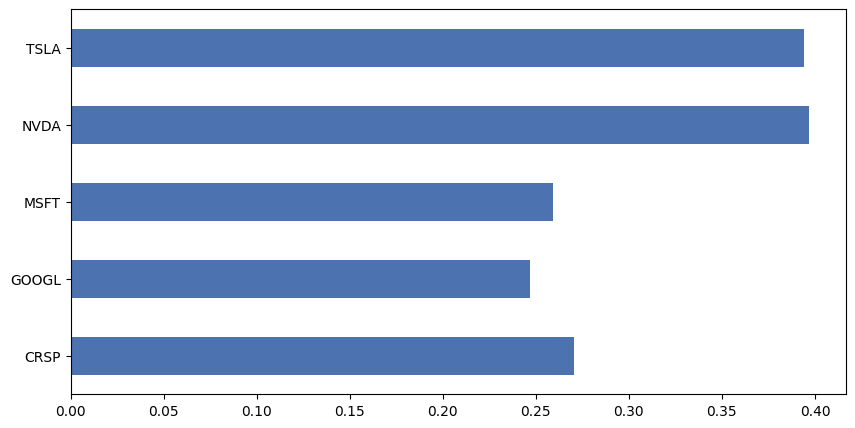

In [45]:
market_prior.plot.barh(figsize=(10,5))

^ How much am I going to be compensated per the risk I am taking on

**Important to note:** This alone does not incorporate any of my own expertise in the matter

How do I integrate that into the process?

## Integrating Views

In [68]:
viewdict = {
    'TSLA': 0.305,  # I believe Tesla will have a 30.5% annual return
    'MSFT': 0.09,   # I believe Microsoft will have a 9% annual return
    'NVDA': 0.10,   # I believe Nvidia will have a 10% annual return
    'GOOGL': 0.08,  # I believe Google will have a 8% annual return
    'CRSP': 0.05    # I believe CRISPR will have a 5% annual return
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

### Creating Confidences

Calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e. bounds which I think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidence.

In [69]:
intervals = [
    (0.20, 0.40),  # I believe Tesla's true annual return will fall between 20% and 40% most of the time
    (0.05, 0.15),  # I believe Microsoft's true annual return will fall between 5% and 15% most of the time
    (0.05, 0.15),  # I believe Nvidia's true annual return will fall between 5% and 15% most of the time
    (0.03, 0.13),  # I believe Google's true annual return will fall between 3% and 13% most of the time
    (0.01, 0.07),  # I believe CRISPR's true annual return will fall between 1% and 7% most of the time
]

In [80]:
# Initialize an empty list to store the variances
variances = []

# Iterate over the confidence intervals
for lb, ub in intervals:
    # Calculate the standard deviation (sigma), which is half the range of the confidence interval
    sigma = (ub - lb) / 2
    # Square the standard deviation to get the variance and append it to the list
    variances.append(sigma ** 2)

# Print out the variances
print(variances)

# Convert the list of variances into a diagonal matrix
# In this matrix, the variances are placed on the diagonal, and all off-diagonal elements are zero
# This is known as the uncertainty matrix (Omega) in the Black-Litterman model, representing the uncertainty of each view
omega = np.diag(variances)

[0.010000000000000002, 0.0024999999999999996, 0.0024999999999999996, 0.0025000000000000005, 0.0009000000000000002]


## Calculate Posterior Estimate Returns

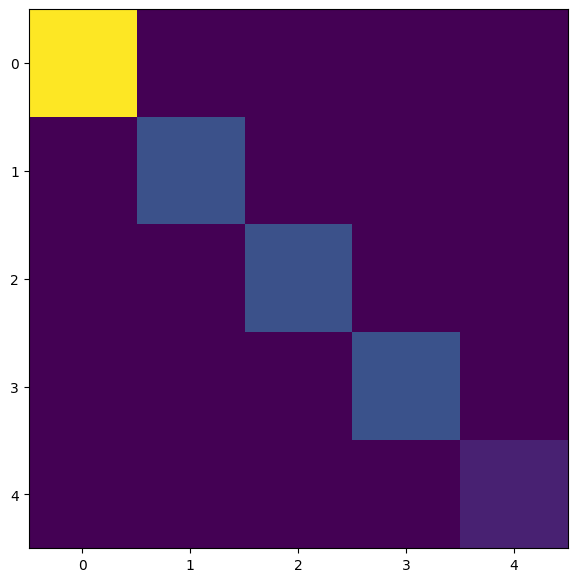

In [71]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(omega)

In [72]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, 
                         pi='market', 
                         market_caps=mcaps, 
                         risk_aversion=delta, 
                         absolute_views=viewdict,
                         omega=omega)

Initiating a **Black-Litterman Model** with the specified parameters. The model combines market equilibrium returns with the investor's personal views to provide updated expected returns and covariances for the portfolio assets. Here's what each parameter is doing:

**S** is the variance-covariance matrix of the assets' returns.

**pi='market'** specifies that the model uses market equilibrium returns as the prior.

**market_caps=mcaps** provides the market capitalization of each asset, which is used to calculate the market portfolio weights and therefore the market equilibrium returns.

**risk_aversion=delta** is the risk aversion coefficient which is used to calculate the market equilibrium returns. In the context of the Black-Litterman model, this is derived from the market portfolio.

**absolute_views=viewdict** are the investor's personal views on the returns of the assets. The keys of viewdict are the assets, and the values are the expected returns. This dictionary will be combined with the market equilibrium returns to generate the posterior returns.

**omega=omega** is the covariance matrix of the errors from the investor's views. This indicates the investor's confidence in each of their views. The larger the error variance, the less confident the investor is in their view. This is used in the model to balance the market equilibrium returns and the investor's views.

In summary, this line is creating a Black-Litterman model object with the provided parameters. This object can be used to compute the posterior returns and covariance matrix for further analysis or portfolio optimization.

In [73]:
ret_bl = bl.bl_returns()
ret_bl

CRSP     0.053049
GOOGL    0.098617
MSFT     0.108740
NVDA     0.131086
TSLA     0.267512
dtype: float64

In [74]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
                       index=['Prior', 'Posterior', 'Views']).T

rets_df

,Prior,Posterior,Views
CRSP,0.270324,0.053049,0.050
GOOGL,0.247107,0.098617,0.080
MSFT,0.259147,0.108740,0.090
NVDA,0.396710,0.131086,0.100
TSLA,0.393987,0.267512,0.305


<Axes: >

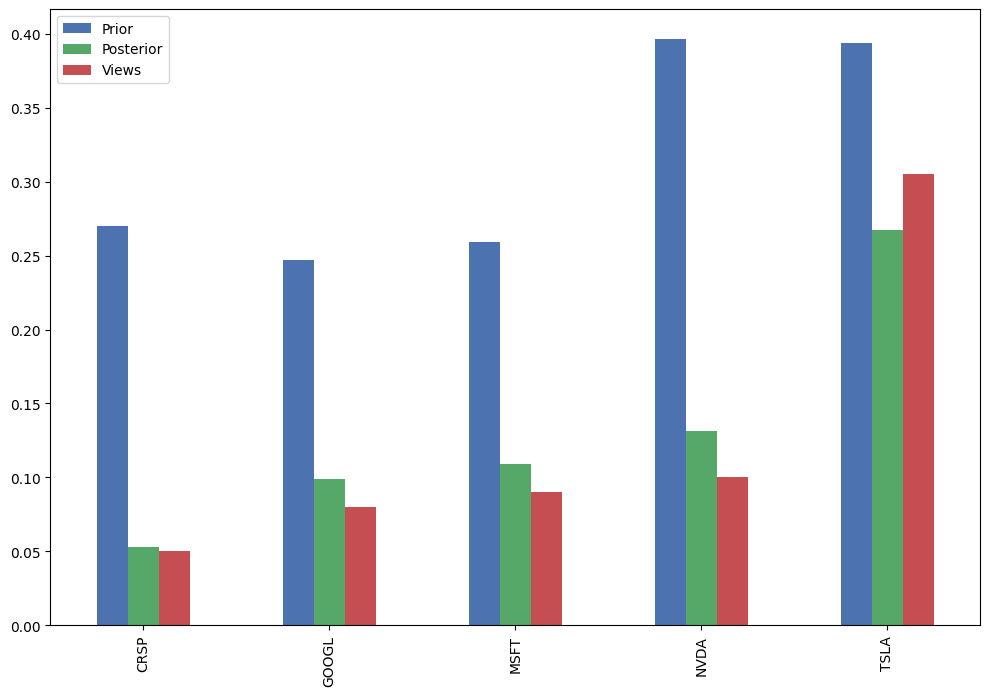

In [75]:
rets_df.plot.bar(figsize=(12,8))

<Axes: >

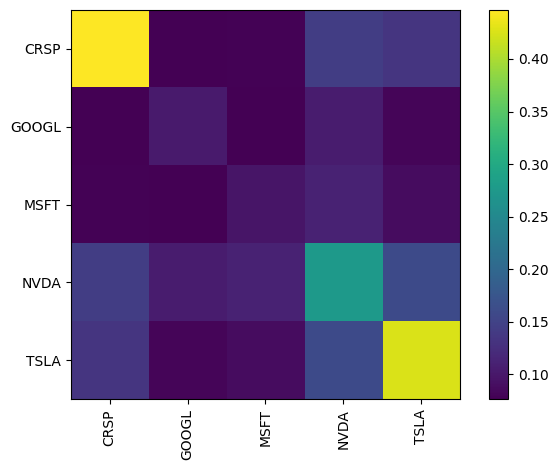

In [76]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl)

## Portfolio Allocation

In [77]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()

weights = ef.clean_weights()
weights

/Users/ryanzola/Documents/Web/python/simple_moving_average/simple_moving_average_env/lib/python3.10/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('CRSP', 0.0),
             ('GOOGL', 0.15272),
             ('MSFT', 0.17905),
             ('NVDA', 0.17668),
             ('TSLA', 0.49154)])

<Axes: >

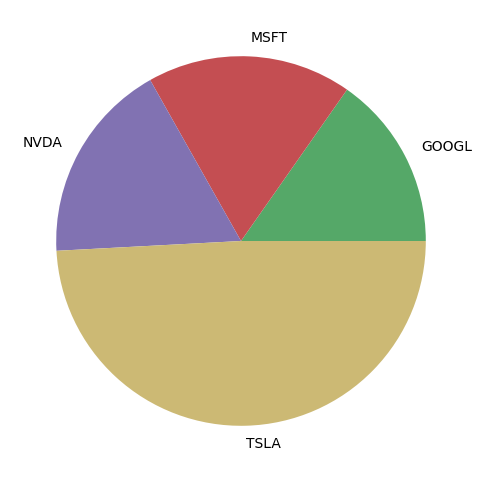

In [78]:
pd.Series(weights).plot.pie(figsize=(6,6))

Expected annual return: 18.9%
Annual volatility: 43.5%
Sharpe Ratio: 0.39


/Users/ryanzola/Documents/Web/python/simple_moving_average/simple_moving_average_env/lib/python3.10/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/ryanzola/Documents/Web/python/simple_moving_average/simple_moving_average_env/lib/python3.10/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(0.1891856270894178, 0.4354459408589703, 0.38853416971961774)

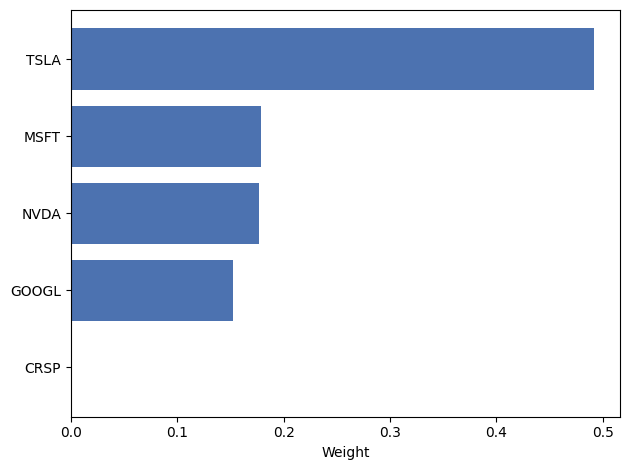

In [79]:
from pypfopt.plotting import plot_weights

# Maximum Sharpe
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()

weights = ef.clean_weights()

plot_weights(weights)
ef.portfolio_performance(verbose=True, risk_free_rate=0.009)